# Frame the Problem

1. **What is the objective?**  
   To understand and quantify the causal relationship between air quality and health outcomes. It is well established that deteriorating air quality can exacerbate conditions such as asthma and heart disease. For point-in-time events (e.g., forest fires, storms) that cause rapid declines in air quality, can we quantify their causal impact on health outcomes? For example, how many incremental emergency room visits for asthma attacks or heart attacks can be causally linked to the LA fires of early 2025?

2. **How will the solution be used?**  
   For now, this will be a standalone data analysis. In theory, cities could use insights from such an analysis to better prepare for spikes in emergency room visits during and after air quality events like fires or storms. Additionally, as the frequency and severity of these events increase due to climate change, this analysis could help forecast the public health costs of inaction on climate issues.

3. **What are current solutions?**  
   A brief search reveals a few similar analyses using machine learning to predict hospital visit volumes based on environmental data such as air quality:

   - [**Predictive Analytics for Emergency Department Visits Based on Local Short-Term Pollution and Weather Exposure**](https://www.researchgate.net/publication/379227522_Predictive_analytics_for_Emergency_Department_visits_based_on_local_short-term_pollution_and_weather_exposure):  
     This study applies machine learning techniques to forecast daily emergency department (ED) visits and hospitalizations for cardiovascular and respiratory conditions in Brescia, Italy (2018–2022). The researchers used Random Forest and ARIMA models, incorporating local air pollution and weather data. They found that the Random Forest model more accurately captured overall trends compared to ARIMA. The findings suggest that integrating environmental data with machine learning can improve ED resource planning and patient care during environmental events.

   - [**Peak Outpatient and Emergency Department Visit Forecasting for Patients With Chronic Respiratory Diseases Using Machine Learning Methods: Retrospective Cohort Study**](https://medinform.jmir.org/2020/3/e13075/?utm_source=chatgpt.com):  
     This retrospective study evaluates machine learning models for predicting peak outpatient and emergency department (OED) visits among patients with chronic respiratory diseases. The models combined air quality and weather data, using methods such as adaptive boosting-based neural networks, tree bagging, and random forests. The Random Forest model achieved the highest performance, with an AUC of 0.809. The study concludes that such models can effectively anticipate patient surges, aiding in proactive medical resource allocation.

4. **How should the problem be framed?**  
   This is primarily a regression task, using ML methods to predict continuous outcomes. The causal analysis is an extension of this task. I plan to use a geo experiment or matched-market framework to estimate causal impact via a counterfactual approach. The accuracy of the causal estimates hinges on the quality of the counterfactual.

5. **How should performance be measured?**  
   In geo experiments, performance is typically evaluated using Minimum Detectable Effect (MDE) and statistical power:

   - **MDE:** The smallest effect size the experiment can reliably detect. A smaller MDE implies greater sensitivity, enabling the detection of subtle effects. It is influenced by factors like KPI variability, the number of geographic units, and experiment duration.
   - **Power:** The probability of detecting a true effect when one exists. A standard threshold is 80%, meaning there is an 80% chance of identifying a real effect. Higher power reduces the risk of Type II errors.

6. **What are comparable problems?**  
   As mentioned, geo experiments are commonly used in marketing to estimate the incremental effect of ad spend on downstream outcomes (e.g., sales). While at Pinterest, I frequently analyzed geo experiment data. Several third-party vendors (e.g., Measured, Nielsen) offer geo experiment platforms, and companies like Google and Meta have released open-source tools—`matched_markets` and `GeoLift`, respectively.

7. **Have any assumptions been made?**  
   Yes. The analysis assumes that data on environmental factors (e.g., air quality, forest fires, storms) and health outcomes (e.g., hospital visits) is readily accessible. It also assumes that the geo experiment framework is applicable to this type of data.


# Get the Data

**What data is needed?**

This analysis requires several types of data:

1. **Environmental factors** — including temperature, humidity, air quality, and related metrics.
   - I will use the EPA Air Quality System (AQS) to obtain this data. The AQS provides daily summary data on pollutants and meteorological conditions. This data is available through [pre-generated data files](https://aqs.epa.gov/aqsweb/airdata/download_files.html) and a [REST API](https://aqs.epa.gov/aqsweb/documents/data_api.html). I will use the API, as it offers more flexibility and supports reproducible workflows.
2. **Health outcomes** — specifically hospital visits, with detailed information on the reasons for each visit.

Ideally, the data should be as granular as possible—preferably at the daily level—since geo experiments rely on time series data.


In [ ]:
# Get API key

import requests
from dotenv import load_dotenv
import os 

load_dotenv()

email = os.getenv("EMAIL")
url = "https://aqs.epa.gov/data/api/signup"
params = {
    "email": email
}

# response = requests.get(url, params=params)

# if response.status_code == 200:
#     print("Successfully signed up for the EPA AQS API.")
# else:   
#     print(f"Failed to sign up for the EPA AQS API. Status code: {response.status_code}")
#     print("Response:", response.text)

api_key = os.getenv("API_KEY")

In [ ]:
# Parameter classes

import pandas as pd

url = "https://aqs.epa.gov/data/api/list/classes"
params = {
    "email": email, 
    "key": api_key
}

def get_aqs_data(url, params):
    response = requests.get(url, params=params)
    if response.status_code == 200:
        print("Successfully got data.")
        data = response.json()
        if data["Data"]:
            df = pd.DataFrame(data["Data"])
            return df
        else:
            print("No data returned for given parameters.")
    else:
        print(f"Failed to get data. Status code: {response.status_code}")
        print("Response:", response.text)

parameter_classes = get_aqs_data(url, params)
parameter_classes

Successfully got data.


,code,value_represented
0,AIRNOW MAPS,The parameters represented on AirNow maps (881...
1,ALL,Select all Parameters Available
2,AQI POLLUTANTS,Pollutants that have an AQI Defined
3,CORE_HAPS,Urban Air Toxic Pollutants
4,CRITERIA,Criteria Pollutants
5,CSN DART,List of CSN speciation parameters to populate ...
6,FORECAST,Parameters routinely extracted by AirNow (STI)
7,HAPS,Hazardous Air Pollutants
8,IMPROVE CARBON,IMPROVE Carbon Parameters
9,IMPROVE_SPECIATION,PM2.5 Speciated Parameters Measured at IMPROVE...


In [3]:
# Parameters by class 

url = "https://aqs.epa.gov/data/api/list/parametersByClass"
params = {
    "email": email, 
    "key": api_key, 
    "pc": "AIRNOW MAPS"
}

parameters_by_class = get_aqs_data(url, params)
parameters_by_class

Successfully got data.


,code,value_represented
0,44201,Ozone
1,88101,PM2.5 - Local Conditions
2,88502,Acceptable PM2.5 AQI & Speciation Mass


In [ ]:
# CBSAs 

url = "https://aqs.epa.gov/data/api/list/cbsas"
params = {
    "email": email, 
    "key": api_key, 
}

cbsa = get_aqs_data(url, params)
cbsa.head()

Successfully got data.


,code,value_represented
0,10020,"Abbeville, LA"
1,10100,"Aberdeen, SD"
2,10140,"Aberdeen, WA"
3,10180,"Abilene, TX"
4,10220,"Ada, OK"


In [5]:
# Test, get AQI data for a single CBSA 
# CBSA: New York-Newark-Jersey City, NY-NJ-PA (Code 35620)

url = "https://aqs.epa.gov/data/api/dailyData/byCBSA"
params = {
    "email": email, 
    "key": api_key, 
    "param": "88101", 
    "bdate": "20230101", 
    "edate": "20231231", 
    "cbsa": "35620"
}

ny_daily_pm25 = get_aqs_data(url, params)
ny_daily_pm25.info()

Successfully got data.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60287 entries, 0 to 60286
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state_code            60287 non-null  object 
 1   county_code           60287 non-null  object 
 2   site_number           60287 non-null  object 
 3   parameter_code        60287 non-null  object 
 4   poc                   60287 non-null  int64  
 5   latitude              60287 non-null  float64
 6   longitude             60287 non-null  float64
 7   datum                 60287 non-null  object 
 8   parameter             60287 non-null  object 
 9   sample_duration_code  60287 non-null  object 
 10  sample_duration       60287 non-null  object 
 11  pollutant_standard    55036 non-null  object 
 12  date_local            60287 non-null  object 
 13  units_of_measure      60287 non-null  object 
 14  event_type            60287 non-null  object 
 

In [41]:
# Explore raw data from NY CBSA 

# Sample sorted data 
ny_daily_pm25.sort_values(['date_local', 'site_number']).head(1000)

# Number of records per site
ny_daily_pm25.groupby(['date_local', 'site_number'])['aqi'].count().reset_index().sort_values(['date_local', 'site_number'])

# Number of sites 
ny_daily_pm25['site_number'].nunique()

# Aggregate so that each day has a single row --> simple arithmetic mean 
ny_daily_pm25.groupby(['date_local'])['aqi'].mean().reset_index().sort_values('date_local', ascending=True)

# Combine different aggregation techniques 

# More aggregation techniques: median 
ny_daily_pm25.groupby(['date_local'])['aqi'].median().reset_index().sort_values('date_local', ascending=True)

# More aggregation techniques: max 
ny_daily_pm25.groupby(['date_local'])['aqi'].max().reset_index().sort_values('date_local', ascending=True)

# Multiple aggregation techniques at once 
ny_daily_pm25.groupby(['date_local']).agg(mean_aqi=('aqi', 'mean'), median_aqi=('aqi', 'median'), max_aqi=('aqi', 'max'))

# Validity indicator 
ny_daily_pm25.groupby('validity_indicator')['aqi'].count()

validity_indicator
N        0
Y    55036
Name: aqi, dtype: int64

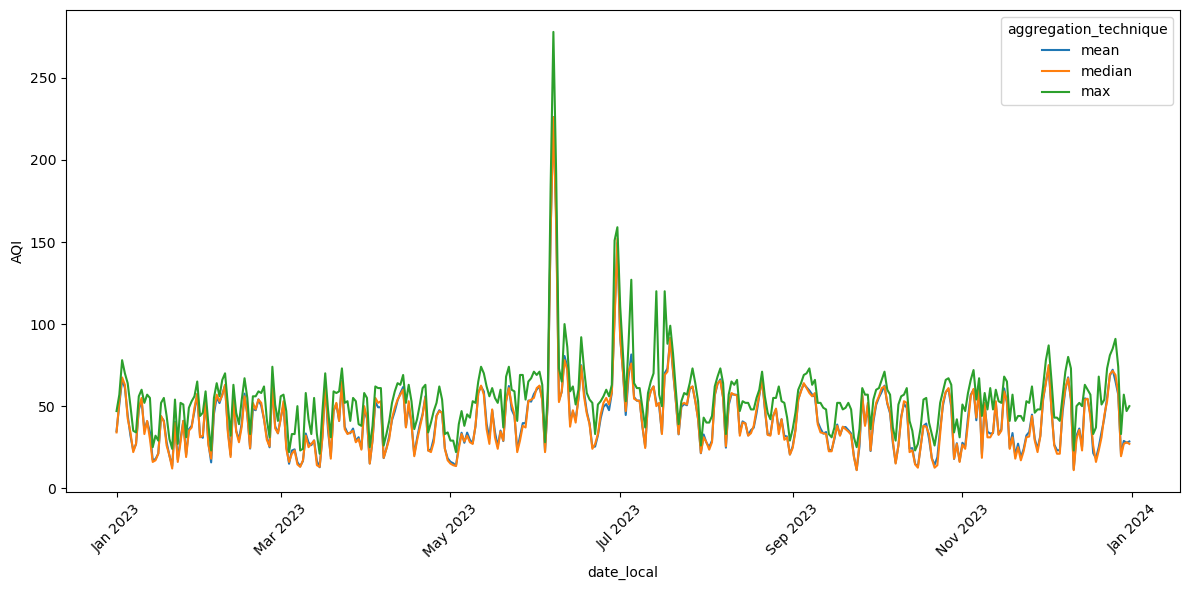

In [39]:
# Compare different aggregation methods for AQI 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

agg_ny_daily_pm25 = ny_daily_pm25.groupby(['date_local']).agg(mean=('aqi', 'mean'), median=('aqi', 'median'), max=('aqi', 'max')).reset_index()
agg_ny_daily_pm25['date_local'] = pd.to_datetime(agg_ny_daily_pm25['date_local'], format='%Y-%m-%d')

# Convert to long format for Seaborn
agg_ny_daily_pm25 = agg_ny_daily_pm25.melt(id_vars='date_local', var_name='aggregation_technique', value_name='AQI')

plt.figure(figsize=(12, 6))
sns.lineplot(data=agg_ny_daily_pm25, x='date_local', y='AQI', hue='aggregation_technique')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan 2024

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()